In [1]:
from make_dataloader import CustomDataset
from torch.utils.data import Dataset, DataLoader
import torchvision
train_2_dataset = CustomDataset('train', 'A2C', torchvision.transforms.ToTensor())
train_4_dataset = CustomDataset('train', 'A4C', torchvision.transforms.ToTensor())
val_2_dataset = CustomDataset('validation', 'A2C', torchvision.transforms.ToTensor())
val_4_dataset = CustomDataset('validation', 'A4C', torchvision.transforms.ToTensor())
train_2_4_dataset= []
test_2_4_dataset = []
for i in range(len(train_2_dataset)):
    train_2_4_dataset.append(train_2_dataset[i])
    train_2_4_dataset.append(train_4_dataset[i])
for j in range(len(val_2_dataset)):
    test_2_4_dataset.append(val_2_dataset[j])
    test_2_4_dataset.append(val_4_dataset[j])
    

train_loader= DataLoader(train_2_4_dataset, batch_size=8)
valid_loader= DataLoader(test_2_4_dataset, batch_size=8)
# train_2_dataloader = DataLoader(train_2_dataset, batch_size=40, shuffle=False)
# train_4_dataloader = DataLoader(train_2_dataset, batch_size=40, shuffle=False)
# val_2_dataloader = DataLoader(val_2_dataset, batch_size=40, shuffle=False)
# val_4_dataloader = DataLoader(val_4_dataset, batch_size=40, shuffle=False)


In [3]:
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
import torch
image, mask = next(iter(valid_loader))
#train_2_dataset[4]
torch.sum((mask>0)&(mask<1))
# visualize(image=image, mask=mask)


tensor(0)

In [6]:
mask.max()

tensor(1, dtype=torch.int32)

In [ ]:
from metrics import get_DC, get_JS
from tqdm import tqdm
import os
import numpy as np
def main(args):

    device = torch.device("cuda:0")

    loaders = {"train": train_loader, "valid": valid_loader}
    unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)

    unet.to(device)

    best_validation_dsc =np.inf 

    optimizer = torch.optim.Adam(unet.parameters(), lr=args.lr)

    loss_train = []
    loss_valid = []

    for epoch in tqdm(range(args.epochs), total=args.epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()


            for i, data in enumerate(loaders[phase]):

                x, y_true = data
                x, y_true = x.to(device), y_true.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)

                    loss = get_DC(y_pred, y_true)

                    if phase == "valid":
                        loss_valid.append(loss.item())

                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()

                if loss_valid[-1]< best_validation_dsc:
                    best_validation_dsc = loss_valid[-1] 
                    torch.save(unet.state_dict(), "unet.pth")
                loss_valid = []

    print("Best validation mean DSC: {:4f}".format(best_validation_dsc))

In [11]:
from unet import pretrained_unet
import numpy as np
import torch
def evaluate(model, testloader, mode='base'):
    img_list = []
    pred_mask_list = []
    gt_mask_list = []
    model.eval()
    with torch.no_grad():
        for img, gt_mask in testloader:
            output = model(img.cuda().permute(0,3,1,2))
            # output = model(img.cuda())
            if mode=='base': # 일반적인 모델
                pred_mask_list.append(output.cpu().numpy())
            elif mode=='caranet': # 종욱이 모델
                pred_mask_list.append(output[0].sigmoid().cpu().numpy()) 


            gt_mask_list.append(gt_mask.numpy())
    pred_mask_list = np.vstack(pred_mask_list)
    gt_mask_list = np.vstack(gt_mask_list)
    pred_mask_list_hard = ((pred_mask_list > 0.5) + 0).transpose(0, 2, 3, 1)
    gt_mask_list.shape, pred_mask_list_hard.shape
    
    DS_list = []
    for i, gt_mask in enumerate(gt_mask_list):
        Inter = np.sum((pred_mask_list_hard[i] + gt_mask) == 2)*2
        Union = np.sum(pred_mask_list_hard[i]) + np.sum(gt_mask)
        DS = Inter / (Union + 1e-8)
        DS_list.append(DS)
    DS_mean = np.mean(DS_list)

    JS_list = []
    for i, gt_mask in enumerate(gt_mask_list):
        Inter = np.sum((pred_mask_list_hard[i] + gt_mask) == 2)
        Union = np.sum((pred_mask_list_hard[i] + gt_mask) >= 1)
        JS = Inter / (Union + 1e-8)
        JS_list.append(JS)
    JS_mean = np.mean(JS_list)
    print(f'Dice Similarity:    {DS_mean:0.4f} \nJaccard Similarity: {JS_mean:0.4f}')
    return DS_mean, JS_mean
model = pretrained_unet(False).cuda()
model.load_state_dict(torch.load('./unet.pth'))
DS_mean, JS_mean = evaluate(model, valid_loader)




Dice Similarity:    0.9474 
Jaccard Similarity: 0.9020


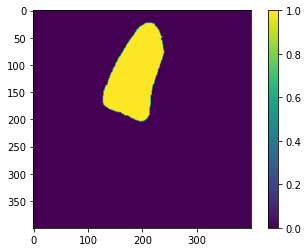

In [5]:
import matplotlib.pyplot as plt
plt.imshow(true[1].permute(1,2,0).cpu().detach().numpy())
plt.colorbar()

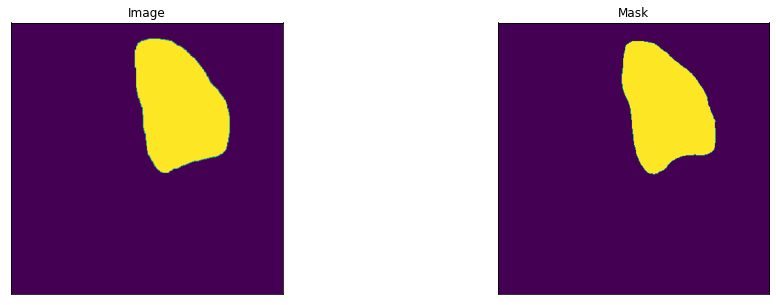

In [6]:
mask_int = (mask>0.001)+0
visualize(image=true[0].permute(1,2,0).cpu().detach().numpy(), mask = mask_int[0].permute(1,2,0).cpu().detach().numpy())


In [12]:
from unet import pretrained_unet
import torch
model = pretrained_unet(False)
model.load_state_dict(torch.load('./unet.pth'))
for (image, mask) in valid_loader:
    true = mask
    model = model.cuda()
    image = image.cuda()
    mask = model(image)
    mask_imt = (mask > 0.5)+0
    break

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[8, 400, 400, 3] to have 3 channels, but got 400 channels instead

In [62]:
import numpy as np
from metrics import get_DC
JS = get_JS(mask[0].cpu().detach(), true[0].cpu().detach(), 0.5)
DC = get_DC(mask[0].cpu().detach(), true[0].cpu().detach(), 0.5)
print(JS, DC)

(0.45677341750830586, tensor(9114)) 0.0


In [27]:

def get_JS(SR,GT,threshold=0.5):
    # JS : Jaccard similarity
    SR = SR > threshold
    
    Inter = torch.sum((SR+GT)==2)
    Union = torch.sum((SR+GT)>=1)
    
    JS = float(Inter)/(float(Union) + 1e-6)
    
    return JS, Inter

def get_DC(SR,GT,threshold=0.5):
    # DC : Dice Coefficient
    SR = SR > threshold
    # GT = GT == torch.max(GT)

    Inter = torch.sum((SR+GT)==2)
    DC = float(2*Inter)/(float(torch.sum(SR)+torch.sum(GT)) + 1e-6)

    return DC, torch.max(GT)


In [28]:
import numpy as np
DC, max_GT = get_DC(mask[0].cpu().detach(), true[0].cpu().detach(), 0.5)

In [29]:
DC

0.9506066402901843

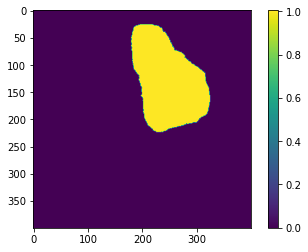

In [37]:
import matplotlib.pyplot as plt
plt.imshow((SR+GT).permute(1,2,0))
plt.colorbar()

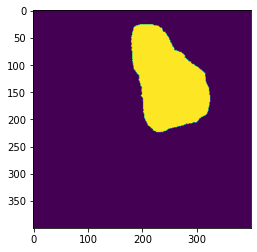

In [38]:
plt.imshow((SR).permute(1,2,0))

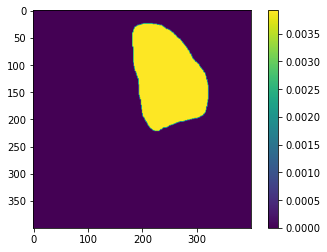

In [39]:

plt.imshow((GT).permute(1,2,0))
plt.colorbar()

In [41]:
print(GT.max())

tensor(0.0039)
